In [1]:
from __future__ import print_function, division

import os
import sys
import re
import pdb
import time

import numpy as np
import scipy as sp
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

print('sys_version:', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('tf ', tf.__version__)


from IPython.core.debugger import Tracer
BREAK_POINT = lambda: Tracer()()

sys_version: 2.7.5 (default, Apr  3 2014, 04:38:53) [GCC 4.7.3]
virtual_env /home/mratkovic/.virtualenvs/py27_tf_env
pwd /home/mratkovic/fer-deep-learning/DU4
np  1.11.2
tf  0.10.0


In [2]:
def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))



In [3]:
# utils.py

""" This file contains different utility functions that are not connected
in anyway to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.

For example ``tile_raster_images`` helps in generating a easy to grasp
image from a set of samples or weights.
"""

import numpy


def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar


def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.

    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).

    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.

    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image

    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)

    :param output_pixel_vals: if output should be pixel values (i.e. int8
    values) or floats

    :param scale_rows_to_unit_interval: if the values need to be scaled before
    being plotted to [0,1] or not


    :returns: array suitable for viewing as an image.
    (See:`Image.fromarray`.)
    :rtype: a 2-d array with same dtype as X.

    """

    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = numpy.zeros((out_shape[0], out_shape[1], 4),
                                    dtype='uint8')
        else:
            out_array = numpy.zeros((out_shape[0], out_shape[1], 4),
                                    dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                dt = out_array.dtype
                if output_pixel_vals:
                    dt = 'uint8'
                out_array[:, :, i] = numpy.zeros(
                    out_shape,
                    dtype=dt
                ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(
                    X[i], img_shape, tile_shape, tile_spacing,
                    scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        dt = X.dtype
        if output_pixel_vals:
            dt = 'uint8'
        out_array = numpy.zeros(out_shape, dtype=dt)

        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(
                            this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    c = 1
                    if output_pixel_vals:
                        c = 255
                    out_array[
                        tile_row * (H + Hs): tile_row * (H + Hs) + H,
                        tile_col * (W + Ws): tile_col * (W + Ws) + W
                    ] = this_img * c
        return out_array


# Zadatak 1

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
import math

#from utils import tile_raster_images

In [5]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.nn.relu(
        tf.sign(probs - tf.random_uniform(tf.shape(probs))))


def draw_weights(W, shape, N, interpolation="bilinear"):
    """Vizualizacija težina
    
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    """
    image = Image.fromarray( tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/20)), 20),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
    plt.tight_layout()

In [6]:
# my utils

def get_w1_grad(v, h):    
    v = tf.reshape(v, [-1, int(v.get_shape()[1]), 1])
    h = tf.reshape(h, [-1, 1, int(h.get_shape()[1])])
    # batch i vanjski produkt
    product = tf.reduce_sum(tf.batch_matmul(v, h), reduction_indices=0) 
    return product

In [7]:
# load dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images,mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [37]:
class RBM1:
    def __init__(self, Nv, v_shape, Nh, h1_shape, gibbs_sampling_steps, alpha):

        self.g1 = tf.Graph()
        with self.g1.as_default():
            X1 = tf.placeholder("float", [None, 784])
            w1 = weights([Nv, Nh])
            vb1 = bias([Nv])
            hb1 = bias([Nh])

            v0 = X1  
            h0_prob = tf.nn.sigmoid(tf.matmul(v0, w1) + tf.transpose(hb1))
            h0 = sample_prob(h0_prob)
            h1 = h0

            for step in range(gibbs_sampling_steps):
                v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1)) 
                v1 = sample_prob(v1_prob)
                h1_prob = tf.nn.sigmoid(tf.matmul(v1, w1) + tf.transpose(hb1))
                h1 = sample_prob(h1_prob)

            # negative samples at end
            # v1 and h1
            # point estimates

            # pozitivna faza
            w1_positive_grad = get_w1_grad(X1, h0_prob)

            # negativna faza
            w1_negative_grad = get_w1_grad(v1_prob, h1_prob)    

            dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0])

            # operacije za osvježavanje parametara mreže - one pokreću učenje RBM-a
            update_w1 = tf.assign_add(w1, alpha * dw1)
            update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(X1 - v1_prob, 0))
            update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

            self.out1 = (update_w1, update_vb1, update_hb1)
            
            # store
            self.vb1 = vb1
            self.hb1 = hb1
            self.w1 = w1
            self.v1_prob = v1_prob
            self.h1_prob = h1_prob
            self.h1 = h1
            
            self.Nv = Nv
            self.Nh = Nh
            self.v_shape = v_shape
            self.h1_shape = h1_shape
            
            self.X1 = X1
            

            # rekonstrukcija ualznog vektora - koristimo vjerojatnost p(v=1)
            v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1)) 

            err1 = X1 - v1_prob
            self.err_sum1 = tf.reduce_mean(err1 * err1)

            self.initialize1 = tf.initialize_all_variables()
            
        
    def train(self, batch_size, epochs, mnist):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        self.sess = tf.Session(graph=self.g1)

        self.sess.run(self.initialize1)
        for i in range(total_batch):
            batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess.run([self.err_sum1, self.out1], feed_dict={self.X1: batch})

            if i%(int(total_batch/10)) == 0:
                print("Batch count: ", i, "  Avg. reconstruction error: ", err)

    def plot_all(self):
        w1s = self.sess.run(self.w1)
        vb1s = self.sess.run(self.vb1)
        hb1s = self.sess.run(self.hb1)
        vr, h1_probs, h1s = self.sess.run([self.v1_prob, self.h1_prob, self.h1], feed_dict={self.X1: teX[0:20,:]})

        # vizualizacija težina
        draw_weights(w1s, self.v_shape, self.Nh) 

        # vizualizacija rekonstrukcije i stanja
        draw_reconstructions(teX, vr, h1s, self.v_shape, self.h1_shape)
    
    def get_params(self):
        w1s = self.sess.run(self.w1)
        vb1s = self.sess.run(self.vb1)
        hb1s = self.sess.run(self.hb1)
        return w1s, vb1s, hb1s
    
    def get_vr(self):
        vr = self.sess.run(self.v1_prob, feed_dict={self.X1: teX[0:20,:]})
        return vr
        
        
            
            
            


In [38]:
# net
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

gibbs_sampling_steps = 1
alpha = 0.1 # koeficijent učenja 

batch_size = 100
epochs = 100

rbm = RBM1(Nv, v_shape, Nh, h1_shape, gibbs_sampling_steps, alpha)

In [39]:
rbm.train(batch_size, epochs, mnist)
rbm.plot_all()



Batch count:  0   Avg. reconstruction error:  0.256185
Batch count:  5500   Avg. reconstruction error:  0.0225998
Batch count:  11000   Avg. reconstruction error:  0.0206686
Batch count:  16500   Avg. reconstruction error:  0.0211109


KeyboardInterrupt: 

In [53]:
# eval and plot

  


In [54]:
# Zadatak 2

In [40]:
class RBM2:
    
    def __init__(self, Nv, v_shape, Nh, h1_shape, Nh2, h2, gibbs_sampling_steps, alpha, w1s):

        self.g2 = tf.Graph()
        with self.g2.as_default():
            X2 = tf.placeholder("float", [None, Nv])
            w1a = tf.Variable(w1s)
            vb1a = tf.Variable(vb1s)
            hb1a = tf.Variable(hb1s)

            w2 = weights([Nh, Nh2])
            vb2 = bias([Nh])
            hb2 = bias([Nh2])

            v1 = X2
            # vidljivi sloj drugog RBM-a
            v2_prob  = tf.nn.sigmoid(tf.matmul(v1, w1a) + tf.transpose(hb1a))
            v2 = sample_prob(v2_prob)

            # skriveni sloj drugog RBM-a
            h2_prob = tf.nn.sigmoid(tf.matmul(v2, w2) + tf.transpose(hb2)) 
            h2 = sample_prob(h2_prob)

            h3 = h2


            for step in range(gibbs_sampling_steps):
                v3_prob = tf.nn.sigmoid(tf.matmul(h3, tf.transpose(w2)) + tf.transpose(vb2)) 
                v3 = sample_prob(v3_prob)

                h3_prob = tf.nn.sigmoid(tf.matmul(v3, w2) + tf.transpose(hb2)) 
                h3 = sample_prob(h3_prob)


            w2_positive_grad = get_w1_grad(v2_prob, h2_prob)
            w2_negative_grad = get_w1_grad(v3_prob, h3_prob)

            dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(v2)[0])

            update_w2 = tf.assign_add(w2, alpha * dw2)
            update_vb2 = tf.assign_add(vb2, alpha * tf.reduce_mean(v2 - v3, 0))
            update_hb2 = tf.assign_add(hb2, alpha * tf.reduce_mean(h2 - h3, 0))

            self.out2 = (update_w2, update_vb2, update_hb2)

            # rekonsturkcija ulaza na temelju krovnog skrivenog stanja h3
            # ??
            v4_prob = tf.nn.sigmoid(tf.matmul(h3, tf.transpose(w2)) + tf.transpose(vb2)) 
            v4 = sample_prob(v4_prob)
            v5_prob = tf.nn.sigmoid(tf.matmul(v4, tf.transpose(w1a)) + tf.transpose(vb1a)) 



            err2 = X2 - v5_prob
            self.err_sum2 = tf.reduce_mean(err2 * err2)

            self.initialize2 = tf.initialize_all_variables()
            
            self.X2 = X2
            self.w2 = w2
            self.vb2 = vb2
            self.hb2 = hb2
            self.v5_prob = v5_prob
            self.h3_prob = h3_prob
            self.h3 = h3
            
            self.Nv = Nv
            self.Nh = Nh
            self.v_shape = v_shape
            self.h1_shape = h1_shape
            
            
            
            
            self.h1_shape = h1_shape
            self.Nh2 = Nh2
            self.v_shape = v_shape
            self.h2_shape = h2_shape
            
    def train(self, batch_size, epochs, mnist):
        n_samples = mnist.train.num_examples

        total_batch = int(n_samples / batch_size) * epochs
        self.sess = tf.Session(graph=self.g2)
        self.sess.run(self.initialize2)

        for i in range(total_batch):
            self.batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess.run([self.err_sum2, self.out2], feed_dict={self.X2: self.batch})

            if i%(int(total_batch/10)) == 0:
                print("Batch count: ", i, "  Avg. reconstruction error: ", err)
        
    def plot_all(self):
        w2s, vb2s, hb2s = self.sess.run([self.w2, self.vb2, self.hb2], feed_dict={self.X2: self.batch})
        vr2, h3_probs, h3s = self.sess.run([self.v5_prob, self.h3_prob, self.h3], feed_dict={self.X2: teX[0:50,:]})

        # vizualizacija težina
        draw_weights(w2s, self.h1_shape, self.Nh2, interpolation="nearest")

        # vizualizacija rekonstrukcije i stanja
        draw_reconstructions(teX, vr2, h3s, self.v_shape, self.h2_shape)
        
        
    def get_params(self):
        w2s, vb2s, hb2s = self.sess.run([self.w2, self.vb2, self.hb2], feed_dict={self.X2: self.batch})
        return w2s, vb2s, hb2s
    
    def get_vr(self):
        vr = self.sess.run(self.v5_prob, feed_dict={self.X2: teX[0:50,:]})
        return vr
        
        

In [41]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

Nh2 = 100
h2_shape = (10,10) 

gibbs_sampling_steps = 2
alpha = 0.1
w1s, vb1s, hb1s = rbm.get_params()

batch_size = 100
epochs = 100


In [42]:
rbm2 = RBM2(Nv, v_shape, Nh, h1_shape, Nh2, h2_shape, gibbs_sampling_steps, alpha, w1s)
rbm2.train(batch_size, epochs, mnist)




Batch count:  0   Avg. reconstruction error:  0.0998861
Batch count:  5500   Avg. reconstruction error:  0.038912


KeyboardInterrupt: 

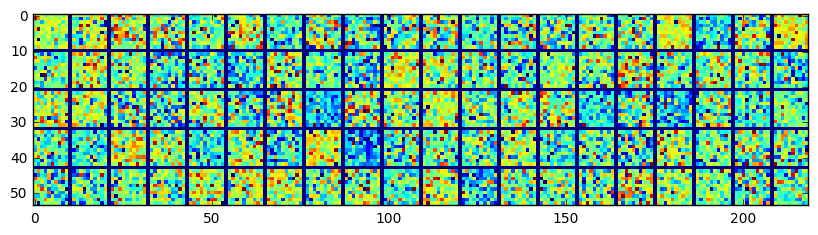

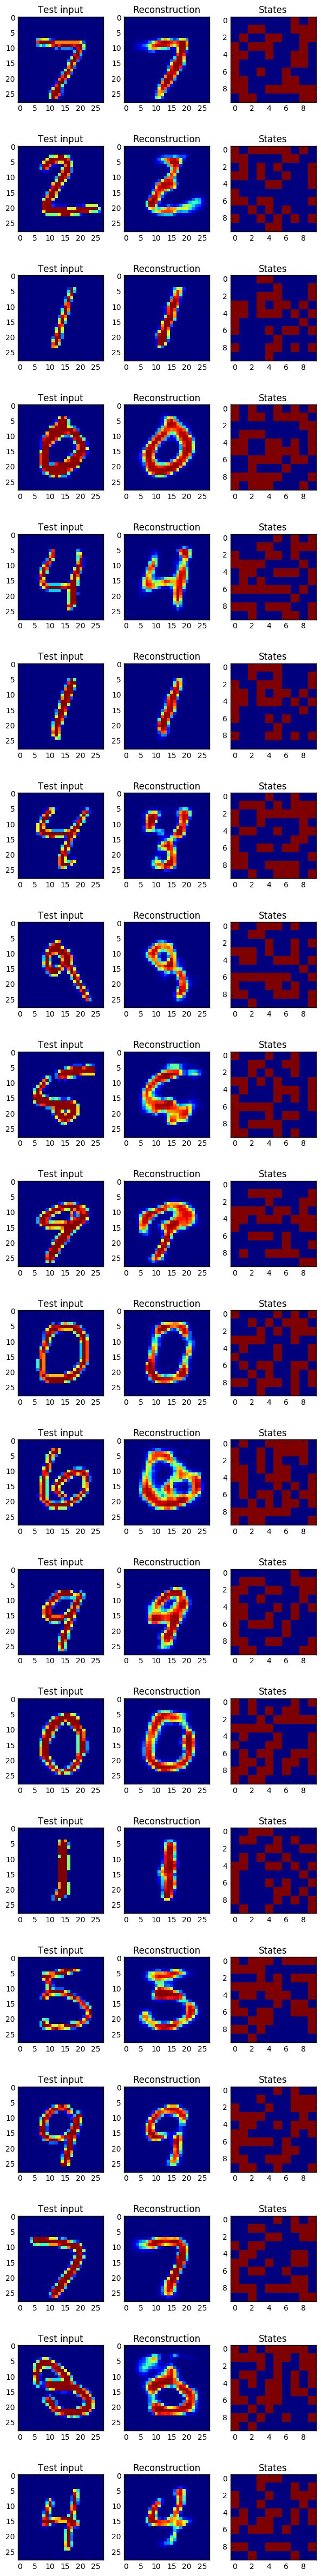

In [43]:
rbm2.plot_all()


# Zadatak 3

In [54]:
class RBM2b:
    def __init__(self, Nv, v_shape, Nh, h1_shape, Nh2, h2, beta, w1s, w2s):

        beta = 0.01

        self.g3 = tf.Graph()
        with self.g3.as_default():   
            X3 = tf.placeholder("float", [None, Nv])


            w1_up = tf.Variable(w1s)
            w1_down = tf.Variable(tf.transpose(w1s))
            w2a = tf.Variable(w2s)

            hb1_up = tf.Variable(hb1s)
            hb1_down = tf.Variable(vb2s)

            vb1_down = tf.Variable(vb1s)
            hb2a = tf.Variable(hb2s)

            v1= X3
            # wake pass
            h1_up_prob = tf.nn.sigmoid(tf.matmul(v1, w1_up) + tf.transpose(hb1_up)) 
            h1_up = sample_prob(h1_up_prob) # s^{(n)} u pripremi

            v1_up_down_prob = tf.nn.sigmoid(tf.matmul(h1_up, w1_down) + tf.transpose(vb1_down)) 
            v1_up_down = sample_prob(v1_up_down_prob) # s^{(n-1)\mathit{novo}} u pripremi


            # top RBM Gibs passes
            h2_up_prob = tf.nn.sigmoid(tf.matmul(h1_up, w2a) + tf.transpose(hb2a)) 
            h2_up = sample_prob(h2_up_prob)
            h4 = h2_up

            for step in range(gibbs_sampling_steps):
                h1_down_prob = tf.nn.sigmoid(tf.matmul(h4, tf.transpose(w2a)) + tf.transpose(hb1_down)) 
                h1_down = sample_prob(h1_down_prob)

                h4_prob = tf.nn.sigmoid(tf.matmul(h1_down, w2a) + tf.transpose(hb2a)) 
                h4 = sample_prob(h4_prob)

            # sleep pass
            v1_down_prob = tf.nn.sigmoid(tf.matmul(h1_down, w1_down) + tf.transpose(vb1_down)) 
            v1_down = sample_prob(v1_down_prob) # s^{(n-1)} u pripremi

            h1_down_up_prob = tf.nn.sigmoid(tf.matmul(v1_down, w1_up) + tf.transpose(hb1_up)) 
            h1_down_up = sample_prob(h1_down_prob) # s^{(n)\mathit{novo}} u pripremi


            # generative weights update during wake pass
            update_w1_down = tf.assign_add(w1_down, beta * tf.matmul(tf.transpose(h1_up), X3 - v1_up_down_prob) / tf.to_float(tf.shape(X3)[0]))
            update_vb1_down = tf.assign_add(vb1_down, beta * tf.reduce_mean(X3 - v1_up_down_prob, 0))

            # top RBM update
            w2_positive_grad = get_w1_grad(h1_up_prob, h2_up_prob)
            w2_negative_grad = get_w1_grad(h1_down_prob, h4_prob)
            dw3 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1_up)[0]) 


            update_w2 = tf.assign_add(w2a, beta * dw3)
            update_hb1_down = tf.assign_add(hb1_down, beta * tf.reduce_mean(h1_up - h1_down, 0))
            update_hb2 = tf.assign_add(hb2a, beta * tf.reduce_mean(h2_up - h4, 0))

            # recognition weights update during sleep pass
            update_w1_up = tf.assign_add(w1_up, beta * tf.matmul(tf.transpose(v1_down_prob), h1_down - h1_down_up) / tf.to_float(tf.shape(X3)[0]))
            update_hb1_up = tf.assign_add(hb1_up, beta * tf.reduce_mean(h1_down - h1_down_up, 0))###########^ #####

            self.out3 = (update_w1_down, update_vb1_down, update_w2, update_hb1_down, update_hb2, update_w1_up, update_hb1_up)

            err3 = X3 - v1_down_prob
            self.err_sum3 = tf.reduce_mean(err3 * err3)

            self.initialize3 = tf.initialize_all_variables()
            
            
            self.X3 = X3
            self.w2a, self.w1_up, self.w1_down, self.hb2a = w2a, w1_up, w1_down, hb2a
            self.hb1_up, self.hb1_down, self.vb1_down =  hb1_up, hb1_down, vb1_down
            self.v1_down_prob, self.h4, self.h4_prob = v1_down_prob, h4, h4_prob
            
            self.h2_up = h2_up
            
            self.Nv = Nv
            self.Nh = Nh
            self.v_shape = v_shape
            self.h1_shape = h1_shape
            
            
            
            
            self.h1_shape = h1_shape
            self.Nh2 = Nh2
            self.v_shape = v_shape
            self.h2_shape = h2_shape
            
    def train(self, batch_size, epochs, mnist):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        self.sess = tf.Session(graph=self.g3)
        self.sess.run(self.initialize3)

        for i in range(total_batch):
            self.batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess.run([self.err_sum3, self.out3], feed_dict={self.X3: self.batch})

            if i%(int(total_batch/10)) == 0:
                print("Batch count: ", i, "  Avg. reconstruction error: ", err)
                
                
                
    def plot_all(self, vr, vr2):
        w2ss, w1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = self.sess.run(
            [self.w2a, self.w1_up, self.w1_down, self.hb2a, self.hb1_up, self.hb1_down, self.vb1_down], feed_dict={self.X3: self.batch})
        
        vr3, h4s, h4_probs = self.sess.run([self.v1_down_prob, self.h4, self.h4_prob], feed_dict={self.X3: teX[0:20,:]})

        # vizualizacija težina
        draw_weights(w1_ups, self.v_shape, self.Nh)
        draw_weights(w1_downs.T, self.v_shape, self.Nh)
        draw_weights(w2ss, h1_shape, self.Nh2, interpolation="nearest")

        # vizualizacija rekonstrukcije i stanja
        Npics = 5
        plt.figure(figsize=(8, 12*4))
        for i in range(20):

            plt.subplot(20, Npics, Npics*i + 1)
            plt.imshow(teX[i].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Test input")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 2)
            plt.imshow(vr[i][0:784].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Reconstruction 1")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 3)
            plt.imshow(vr2[i][0:784].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Reconstruction 2")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 4)
            plt.imshow(vr3[i][0:784].reshape(self.v_shape), vmin=0, vmax=1)
            plt.title("Reconstruction 3")
            plt.axis('off')
            plt.subplot(20, Npics, Npics*i + 5)
            plt.imshow(h4s[i][0:Nh2].reshape(self.h2_shape), vmin=0, vmax=1, interpolation="nearest")
            plt.title("Top states 3")
            plt.axis('off')
            plt.tight_layout()
    
    def random_sample(self):
        w2ss, w1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = self.sess.run([self.w2a, self.w1_up, self.w1_down, self.hb2a, self.hb1_up, self.hb1_down, self.vb1_down], feed_dict={self.X3: self.batch})
        
        vr3, h4s, h4_probs = self.sess.run([self.v1_down_prob, self.h4, self.h4_prob], feed_dict={self.X3: teX[0:20,:]})
        vr3_ = self.sess.run(self.v1_down_prob, feed_dict={self.h2_up: np.random.uniform(size=(1, self.Nh2))})
        return vr3_[0:784].reshape(self.v_shape)
        
        

In [55]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

Nh2 = 100
h2_shape = (10,10) 

gibbs_sampling_steps = 2
beta = 0.01
w1s, vb1s, hb1s = rbm.get_params()
w2s, vb2s, hb2s = rbm2.get_params()

batch_size = 100
epochs = 100


In [56]:
rbm2b = RBM2b(Nv, v_shape, Nh, h1_shape, Nh2, h2_shape, beta, w1s, w2s)
rbm2b.train(batch_size, epochs, mnist)

Batch count:  0   Avg. reconstruction error:  0.0355365


KeyboardInterrupt: 

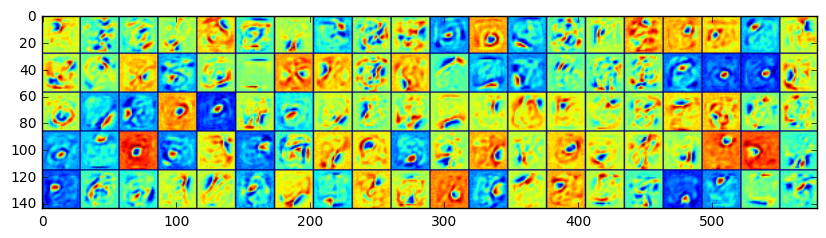

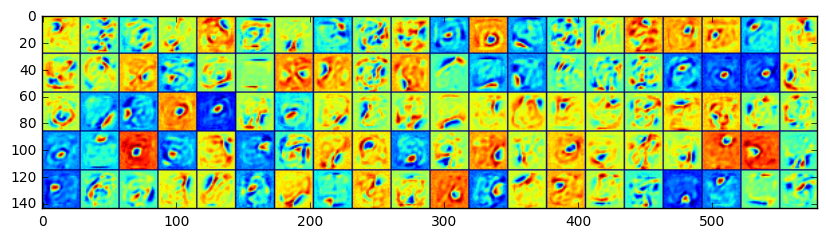

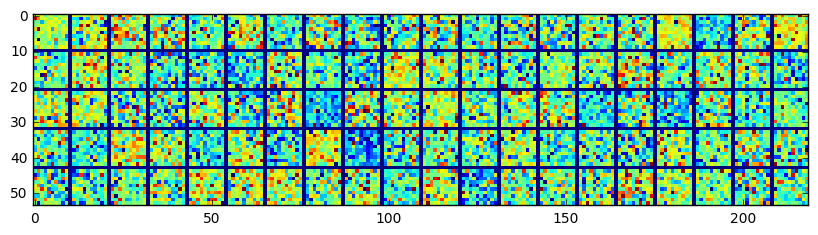

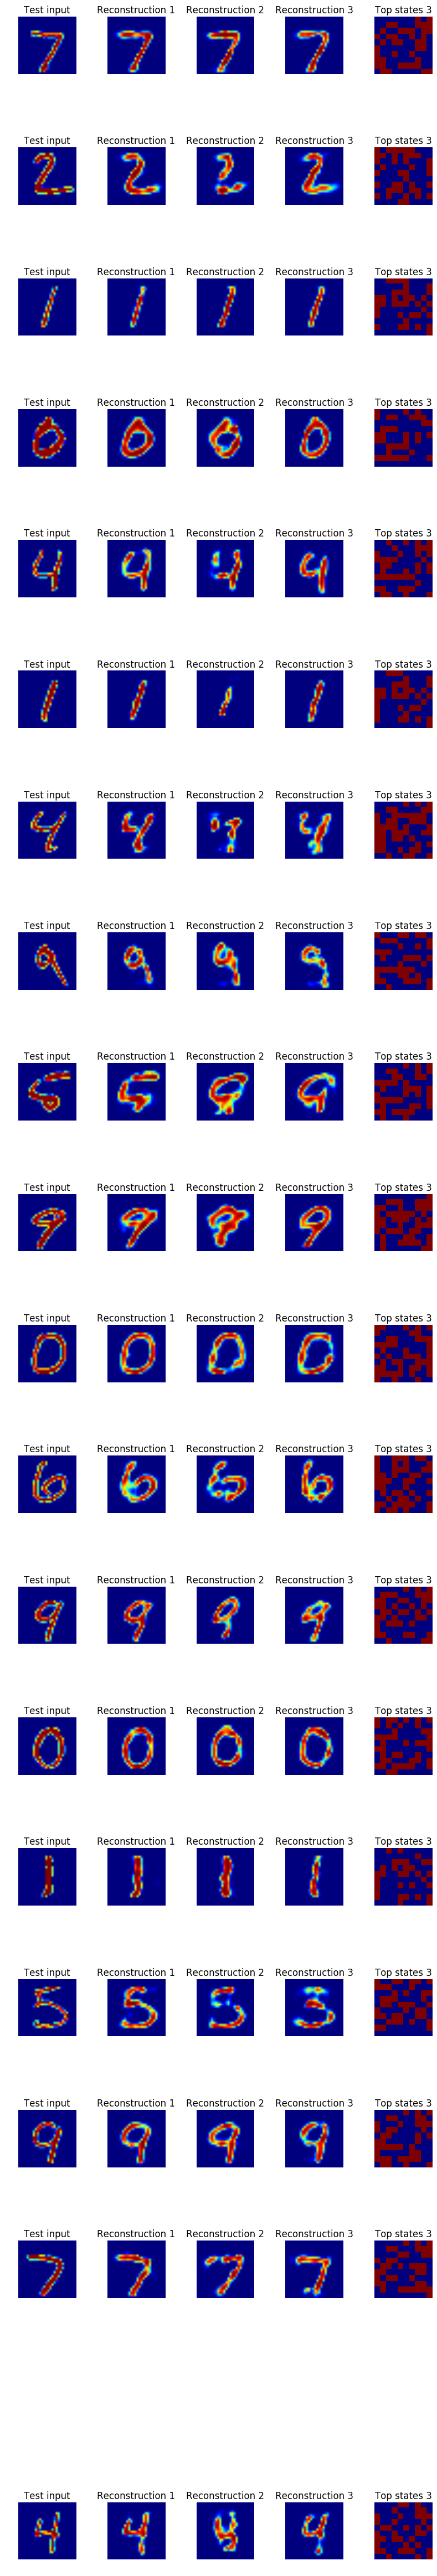

In [51]:
vr1 = rbm.get_vr()
vr2 = rbm2.get_vr()
rbm2b.plot_all(vr1, vr2)

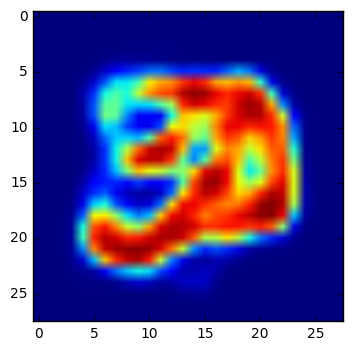

In [58]:
random = rbm2b.random_sample()
plt.imshow(random)

In [63]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

Nh2 = 784
h2_shape = (28,28) 

gibbs_sampling_steps = 2
beta = 0.01
w1s, vb1s, hb1s = rbm.get_params()
w2s, vb2s, hb2s = rbm2.get_params()
hb2s = vb1s.copy()


batch_size = 100
epochs = 100

rbm2b = RBM2b(Nv, v_shape, Nh, h1_shape, Nh2, h2_shape, beta, w1s, w1s.T)
rbm2b.train(batch_size, epochs, mnist)



Batch count:  0   Avg. reconstruction error:  0.0504581


KeyboardInterrupt: 

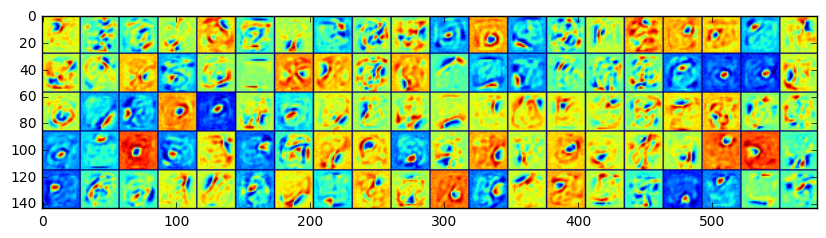

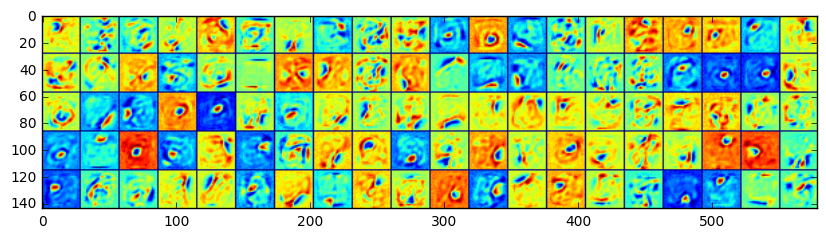

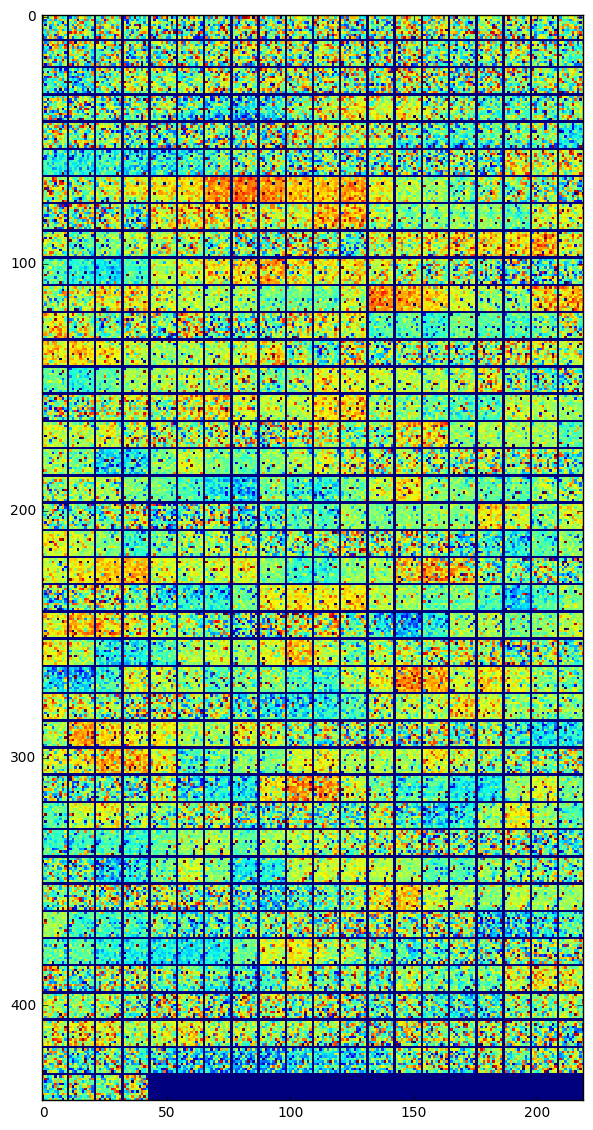

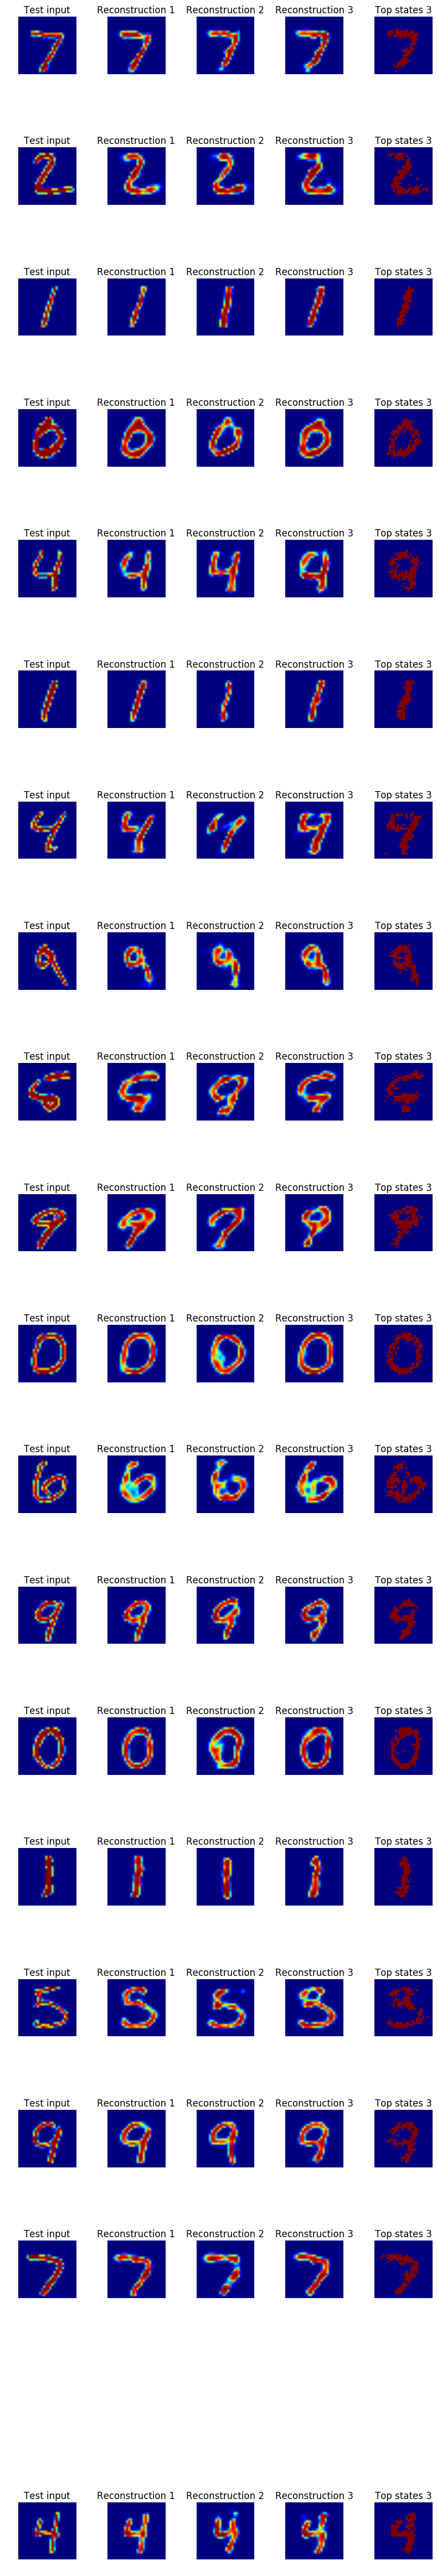

In [64]:

vr1 = rbm.get_vr()
vr2 = rbm2.get_vr()
rbm2b.plot_all(vr1, vr2)

# Zadatak 4

In [67]:
def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state), interpolation="nearest")
        plt.colorbar()
        plt.title("States")
    plt.tight_layout()

def weight_variable(shape, name):
    """Kreiranje težina"""
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    return tf.get_variable(name, shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """Kreiranje pomaka"""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def variable_summaries(var, name):
    """Prikupljanje podataka za Tensorboard"""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

def vae_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softplus):
    """Kreiranje jednog skrivenog sloja"""
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim], layer_name + '/weights')
            variable_summaries(weights, layer_name + '/weights')
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.histogram_summary(layer_name + '/pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.histogram_summary(layer_name + '/activations', activations)
    return activations

In [72]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

learning_rate = 0.001
batch_size = 100

n_hidden_recog_1=200 # 1 sloj enkodera
n_hidden_recog_2=200 # 2 sloj enkodera

n_hidden_gener_1=200 # 1 sloj dekodera
n_hidden_gener_2=200 # 2 sloj dekodera

n_z=20   # broj skrivenih varijabli
n_input=784 # MNIST data input (img shape: 28*28)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [73]:
tf.reset_default_graph() 

sess = tf.InteractiveSession()        
        
# definicije ulaznog tenzora
x = tf.placeholder("float", [None, 784])  

# TODO definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
    # definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity )  
    
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = z_mean + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps
    tf.histogram_summary('z/activations', z)

    
# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)
x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)



# definirajte dvije komponente funkcije cijene
with tf.name_scope('costs'):                         
    # komponenta funkcije cijene - unakrsna entropija
    cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x_reconstr_mean, x), 1)  
    
    
    # komponenta funkcije cijene - KL divergencija
    cost2 = -1/2 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)   
    
    #tf.scalar_summary('cost2', cost2)
    cost = tf.reduce_mean(cost1 + cost2)   # average over batch
    tf.scalar_summary('cost', cost)
                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                         
# Prikupljanje podataka za Tensorboard
merged = tf.merge_all_summaries()                        
train_writer = tf.train.SummaryWriter('train', sess.graph)

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0xf6b2d10>> ignored


In [74]:
init = tf.initialize_all_variables()                         
sess.run(init)

saver = tf.train.Saver()

n_epochs = 100

for epoch in range(n_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        avg_cost += cos / n_samples * batch_size
        
    
    if epoch % 10 == 9:   
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)) 

        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs})
        saver.save(sess, os.path.join('train', "model.ckpt"), epoch)
        train_writer.add_summary(summary, i)

train_writer.close()
        

Epoch: 0010 cost= 107.432555556
Epoch: 0020 cost= 103.003001140
Epoch: 0030 cost= 101.125226773
Epoch: 0040 cost= 100.030153573
Epoch: 0050 cost= 99.282088817
Epoch: 0060 cost= 98.705328244
Epoch: 0070 cost= 98.271806752
Epoch: 0080 cost= 97.905080123
Epoch: 0090 cost= 97.613084495
Epoch: 0100 cost= 97.369699332


Epoch: 0010 cost= 150.356369268


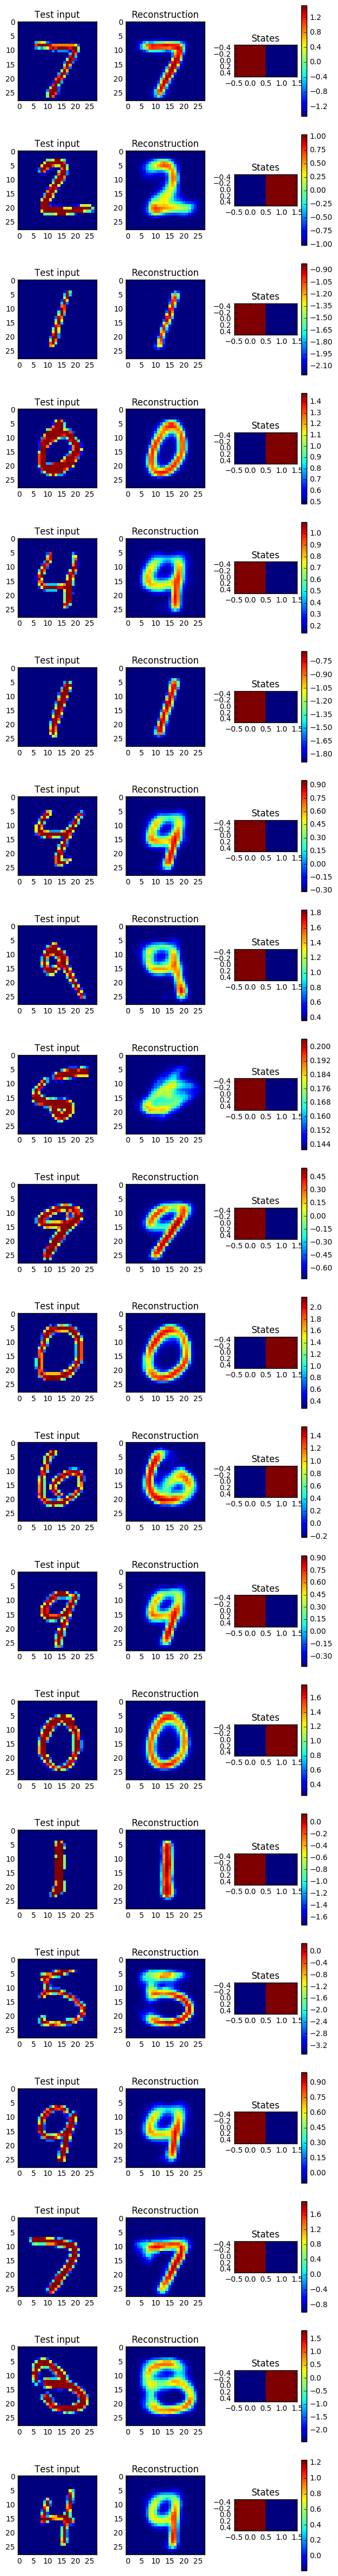

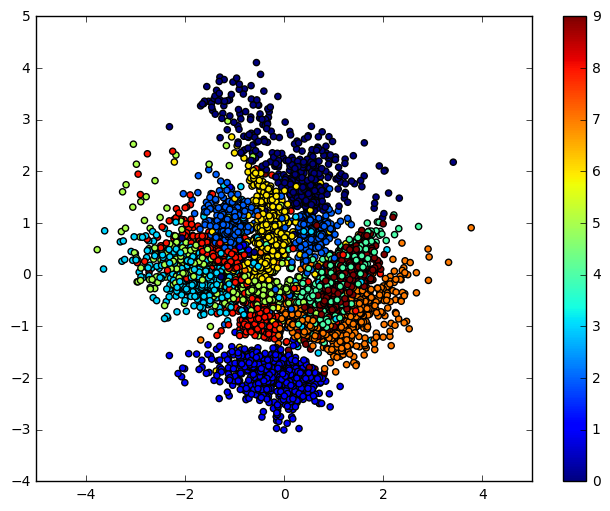

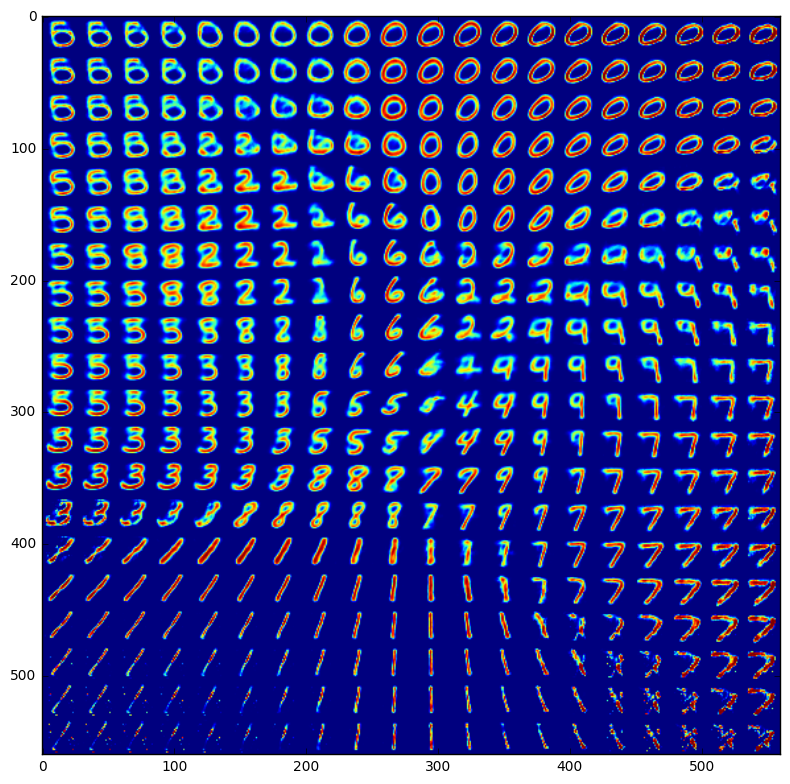

In [71]:
# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})

draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (1,2))

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(z_mean, feed_dict={x: x_sample})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = sess.run(x_reconstr_mean_out, feed_dict={z: np.repeat(z_mu,100,0)})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()

In [ ]:
# dim(z) = 100
# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})

draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (1,20))

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(z_mean, feed_dict={x: x_sample})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = sess.run(x_reconstr_mean_out, feed_dict={z: np.repeat(z_mu,100,0)})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()